# Semantic Segmentation with U-Net
**Author:** Hamayl Zahid  
**Framework:** PyTorch  
**Dataset:** CamVid (32 semantic classes)  
**Goal:** Pixel-level segmentation to detect or mask specific regions (objects, defects, or products) in images.


## Project Goal

The main objective of this project is to perform **semantic segmentation** on images to identify and mask specific regions, such as:  

- Products  
- Defects or damaged areas  
- Background vs. foreground  

**Why it matters:**  
- Enables **pixel-level understanding** of images.  
- Supports **background removal**, **object localization**, and **mask creation** for downstream tasks.  
- Applicable in manufacturing, autonomous driving, and image editing pipelines.


## Approach

1. **Dataset Preparation**  
   - Images and masks resized to 256×256.  
   - Masks converted from RGB to class indices using a **color map**.  
   - Transforms applied to images (e.g., `ToTensor()`).

2. **Model Architecture**  
   - **U-Net** with pre-trained encoder (ResNet50/FCN backbone).  
   - Encoder frozen to leverage pre-trained features.  
   - Decoder trained to predict masks for 32 semantic classes.

3. **Training Setup**  
   - **Loss:** CrossEntropyLoss (multi-class segmentation).  
   - **Optimizer:** Adam.  
   - **Metrics:** Pixel accuracy and Intersection over Union (IoU).

4. **Evaluation & Visualization**  
   - Quantitative evaluation on validation set.  
   - Visualizations include overlay masks, grid of predictions, and class distributions.


In [1]:
import os
import random
from glob import glob
from typing import List, Tuple, Optional


import numpy as np
from PIL import Image
from tqdm import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms.functional as TF


import matplotlib.pyplot as plt

In [2]:
# ==========================================================
# 1. CONFIGURATION
# ==========================================================
class CFG:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    IMG_SIZE = 256
    BATCH_SIZE = 4
    EPOCHS = 15
    LR = 1e-4
    NUM_CLASSES = 32  # CamVid has 32 classes
    DATA_ROOT = r"C:\Users\PMYLS\Downloads\archive (6)\CamVid"

In [3]:
import pandas as pd

# ==========================================================
# Read color → class mapping from class_dict.csv
# ==========================================================
def load_class_map(csv_path):
    df = pd.read_csv(csv_path)
    color_to_class = {}
    for i, row in df.iterrows():
        color_to_class[(row['r'], row['g'], row['b'])] = i
    return color_to_class

def rgb_to_mask(mask_rgb, color_map):
    h, w, _ = mask_rgb.shape
    mask = np.zeros((h, w), dtype=np.int64)
    for color, idx in color_map.items():
        matches = np.all(mask_rgb == color, axis=-1)
        mask[matches] = idx
    return mask



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\PMYLS\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\PMYLS\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\PMYLS\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "C:\Users\PMYLS\anaconda3\Lib\site-packa

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\PMYLS\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\PMYLS\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\PMYLS\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "C:\Users\PMYLS\anaconda3\Lib\site-packa

AttributeError: _ARRAY_API not found

In [4]:

# ==========================================================
# 2. DATASET CLASS
# ==========================================================
class CamVidDataset(Dataset):
    def __init__(self, img_dir, mask_dir, color_map, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.color_map = color_map
        self.images = sorted(glob(os.path.join(img_dir, "*.png")))
        self.masks = sorted(glob(os.path.join(mask_dir, "*.png")))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_rgb = cv2.imread(self.masks[idx])
        mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)

        image = cv2.resize(image, (CFG.IMG_SIZE, CFG.IMG_SIZE))
        mask_rgb = cv2.resize(mask_rgb, (CFG.IMG_SIZE, CFG.IMG_SIZE), interpolation=cv2.INTER_NEAREST)

        mask = rgb_to_mask(mask_rgb, self.color_map)

        if self.transform:
            image = self.transform(image)

        mask = torch.from_numpy(mask).long()
        mask = torch.clamp(mask, max=CFG.NUM_CLASSES - 1)
        return image, mask




In [5]:
# ==========================================================
# 3. TRANSFORMS
# ==========================================================
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])


In [17]:

# ==========================================================
# 4. LOAD DATA
# ==========================================================
color_map = load_class_map(os.path.join(CFG.DATA_ROOT, "class_dict.csv"))

train_dataset = CamVidDataset(
    img_dir=os.path.join(CFG.DATA_ROOT, "train"),
    mask_dir=os.path.join(CFG.DATA_ROOT, "train_labels"),
    color_map=color_map,
    transform=transform,
)
val_dataset = CamVidDataset(
    img_dir=os.path.join(CFG.DATA_ROOT, "val"),
    mask_dir=os.path.join(CFG.DATA_ROOT, "val_labels"),
    color_map=color_map,
    transform=transform,
)
test_dataset = CamVidDataset(
    img_dir=os.path.join(CFG.DATA_ROOT, "test"),
    mask_dir=os.path.join(CFG.DATA_ROOT, "test_labels"),
    color_map=color_map,
    transform=transform,
)
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset, 
    batch_size=CFG.BATCH_SIZE, 
    shuffle=True, 
    num_workers=0, # adjust based on your system
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=CFG.BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=CFG.BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)


CFG.NUM_CLASSES = len(color_map)
print(f"✅ Loaded CamVid with {CFG.NUM_CLASSES} semantic classes.")


✅ Loaded CamVid with 32 semantic classes.


## 🏗️ Model Overview

- **Architecture:** U-Net with pretrained encoder  
- **Input:** RGB images (3 channels)  
- **Output:** Multi-class segmentation mask (32 channels)  
- **Decoder:** Series of Conv2D + ConvTranspose2D layers for upsampling  
- **Frozen Encoder:** Pre-trained features from ResNet50 to speed up training  
- **Training Strategy:** Fine-tune decoder only


In [18]:
# ==========================================================
# 5. MODEL (U-Net with pretrained encoder)
# ==========================================================
from torchvision.models.segmentation import fcn_resnet50

class SimpleUNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleUNet, self).__init__()
        base = fcn_resnet50(pretrained=True)
        self.encoder = base.backbone
        for param in self.encoder.parameters():
            param.requires_grad = False  # Freeze encoder

        self.decoder = nn.Sequential(
            nn.Conv2d(2048, 512, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, num_classes, 2, stride=2)
        )

    def forward(self, x):
        feats = self.encoder(x)["out"] if isinstance(self.encoder(x), dict) else self.encoder(x)
        out = self.decoder(feats)
        return out


model = SimpleUNet(num_classes=CFG.NUM_CLASSES).to(CFG.DEVICE)

C:\Users\PMYLS\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PMYLS\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
# ==========================================================
# 6. LOSS, OPTIMIZER, METRICS
# ==========================================================
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=CFG.LR)

def pixel_accuracy(preds, masks):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == masks).float()
    return correct.sum() / correct.numel()

def iou_score(preds, masks, num_classes):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        intersection = (pred_inds & target_inds).float().sum()
        union = (pred_inds | target_inds).float().sum()
        if union == 0:
            continue
        ious.append((intersection / union).item())
    return np.mean(ious)

In [20]:
# ==========================================================
# Auto-detect number of unique classes in masks
# ==========================================================
import numpy as np
import cv2
from glob import glob
import os

def detect_num_classes(mask_folder):
    unique_vals = set()
    for path in glob(os.path.join(mask_folder, "*.png")):
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        unique_vals.update(np.unique(mask))
    num_classes = int(max(unique_vals) + 1)
    return num_classes

CFG.NUM_CLASSES = detect_num_classes(os.path.join(CFG.DATA_ROOT, "train_labels"))
print(f"✅ Detected {CFG.NUM_CLASSES} unique mask classes.")


✅ Detected 187 unique mask classes.


In [22]:
# ==========================================================
# 7. TRAINING LOOP
# ==========================================================
import cv2

for epoch in range(CFG.EPOCHS):
    model.train()
    train_loss, train_acc = 0, 0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{CFG.EPOCHS}"):
        imgs, masks = imgs.to(CFG.DEVICE), masks.to(CFG.DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += pixel_accuracy(outputs, masks)

    print(f"Epoch [{epoch+1}/{CFG.EPOCHS}] Loss: {train_loss/len(train_loader):.4f} Acc: {train_acc/len(train_loader):.4f}")

    # 🔹 Save checkpoint at the end of the epoch
    torch.save(model.state_dict(), f"unet_epoch{epoch+1}.pth")




Epoch 1/15: 100%|██████████████████████████████████████████████████████████████████████| 93/93 [08:13<00:00,  5.30s/it]


Epoch [1/15] Loss: 1.9286 Acc: 0.3658


Epoch 2/15: 100%|██████████████████████████████████████████████████████████████████████| 93/93 [08:14<00:00,  5.31s/it]


Epoch [2/15] Loss: 1.4395 Acc: 0.5569


Epoch 3/15: 100%|██████████████████████████████████████████████████████████████████████| 93/93 [07:54<00:00,  5.11s/it]


Epoch [3/15] Loss: 1.2801 Acc: 0.6072


Epoch 4/15: 100%|██████████████████████████████████████████████████████████████████████| 93/93 [07:56<00:00,  5.12s/it]


Epoch [4/15] Loss: 1.1573 Acc: 0.6479


Epoch 5/15: 100%|██████████████████████████████████████████████████████████████████████| 93/93 [08:05<00:00,  5.22s/it]


Epoch [5/15] Loss: 1.0830 Acc: 0.6735


Epoch 6/15: 100%|██████████████████████████████████████████████████████████████████████| 93/93 [08:05<00:00,  5.22s/it]


Epoch [6/15] Loss: 1.0321 Acc: 0.6866


Epoch 7/15: 100%|██████████████████████████████████████████████████████████████████████| 93/93 [08:05<00:00,  5.22s/it]


Epoch [7/15] Loss: 1.0050 Acc: 0.7000


Epoch 8/15: 100%|██████████████████████████████████████████████████████████████████████| 93/93 [08:30<00:00,  5.49s/it]


Epoch [8/15] Loss: 0.9636 Acc: 0.7167


Epoch 9/15: 100%|██████████████████████████████████████████████████████████████████████| 93/93 [08:23<00:00,  5.42s/it]


Epoch [9/15] Loss: 0.9312 Acc: 0.7303


Epoch 10/15: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [08:26<00:00,  5.44s/it]


Epoch [10/15] Loss: 0.9128 Acc: 0.7381


Epoch 11/15: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [08:13<00:00,  5.30s/it]


Epoch [11/15] Loss: 0.9066 Acc: 0.7395


Epoch 12/15: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [07:45<00:00,  5.01s/it]


Epoch [12/15] Loss: 0.8772 Acc: 0.7488


Epoch 13/15: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [07:18<00:00,  4.71s/it]


Epoch [13/15] Loss: 0.8654 Acc: 0.7536


Epoch 14/15: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [07:21<00:00,  4.75s/it]


Epoch [14/15] Loss: 0.8457 Acc: 0.7586


Epoch 15/15: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [07:05<00:00,  4.57s/it]


Epoch [15/15] Loss: 0.8337 Acc: 0.7612


In [24]:
# ==========================================================
# 8. EVALUATION & VISUALIZATION (FIXED)
# ==========================================================
model.eval()
with torch.no_grad():
    total_iou, total_acc = 0, 0
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(CFG.DEVICE), masks.to(CFG.DEVICE)
        preds = model(imgs)

        # 🔹 Resize preds to match mask size
        preds = torch.nn.functional.interpolate(
            preds, 
            size=masks.shape[-2:],  # H x W of masks
            mode="bilinear",
            align_corners=False
        )

        total_iou += iou_score(preds, masks, CFG.NUM_CLASSES)
        total_acc += pixel_accuracy(preds, masks)

    print(f"\nValidation IoU: {total_iou/len(val_loader):.4f}, Pixel Acc: {total_acc/len(val_loader):.4f}")



Validation IoU: 0.1853, Pixel Acc: 0.7733


In [26]:
def visualize_overlay(model, dataset, idx=0, alpha=0.5):
    model.eval()
    img, mask = dataset[idx]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(CFG.DEVICE))
        pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(img.permute(1,2,0))  # original image
    ax.imshow(pred_mask, cmap="jet", alpha=alpha)  # predicted overlay
    ax.set_title("Overlay Prediction")
    plt.show()


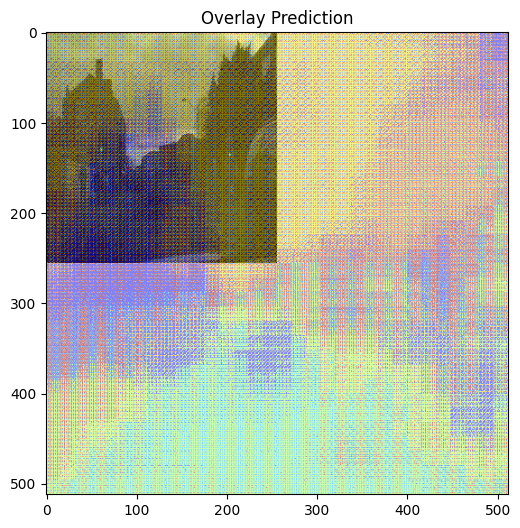

In [30]:
# Show overlay of predicted mask on the original image
visualize_overlay(model, val_dataset, idx=5, alpha=0.5)


In [27]:
import seaborn as sns

def class_distribution(pred_mask, num_classes):
    counts = [np.sum(pred_mask==cls) for cls in range(num_classes)]
    sns.barplot(x=list(range(num_classes)), y=counts)
    plt.title("Predicted Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Pixel Count")
    plt.show()


## 🖼️ Multi-Sample Grid Visualization

Displays a grid of images showing **Input → Ground Truth → Predicted Mask** for multiple samples, allowing quick inspection of the model's performance across the dataset. Useful for identifying strengths and weaknesses without checking images individually.


In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_grid(model, dataset, indices=[0,1,2,3,4]):
    """
    Visualize input images, ground truth, and predicted masks with improved edges.
    """
    model.eval()
    fig, axs = plt.subplots(len(indices), 3, figsize=(12, 3*len(indices)))
    
    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(CFG.DEVICE))
            
            # Resize prediction to input size
            pred = torch.nn.functional.interpolate(pred, size=img.shape[1:], mode='bilinear', align_corners=False)
            
            # Argmax for class labels
            pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy().astype(np.uint8)

            # 🔹 Post-processing to sharpen edges
            kernel = np.ones((3,3), np.uint8)
            pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_CLOSE, kernel)
            pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_OPEN, kernel)
            pred_mask = cv2.dilate(pred_mask, kernel, iterations=1)  # optional for stronger edges

        # Input image
        axs[i,0].imshow(img.permute(1,2,0))
        axs[i,0].set_title("Input")
        axs[i,0].axis("off")

        # Ground Truth
        axs[i,1].imshow(mask, cmap="tab20")
        axs[i,1].set_title("GT")
        axs[i,1].axis("off")

        # Prediction (with improved edges)
        axs[i,2].imshow(pred_mask, cmap="tab20")
        axs[i,2].set_title("Pred")
        axs[i,2].axis("off")

    plt.tight_layout()
    plt.show()


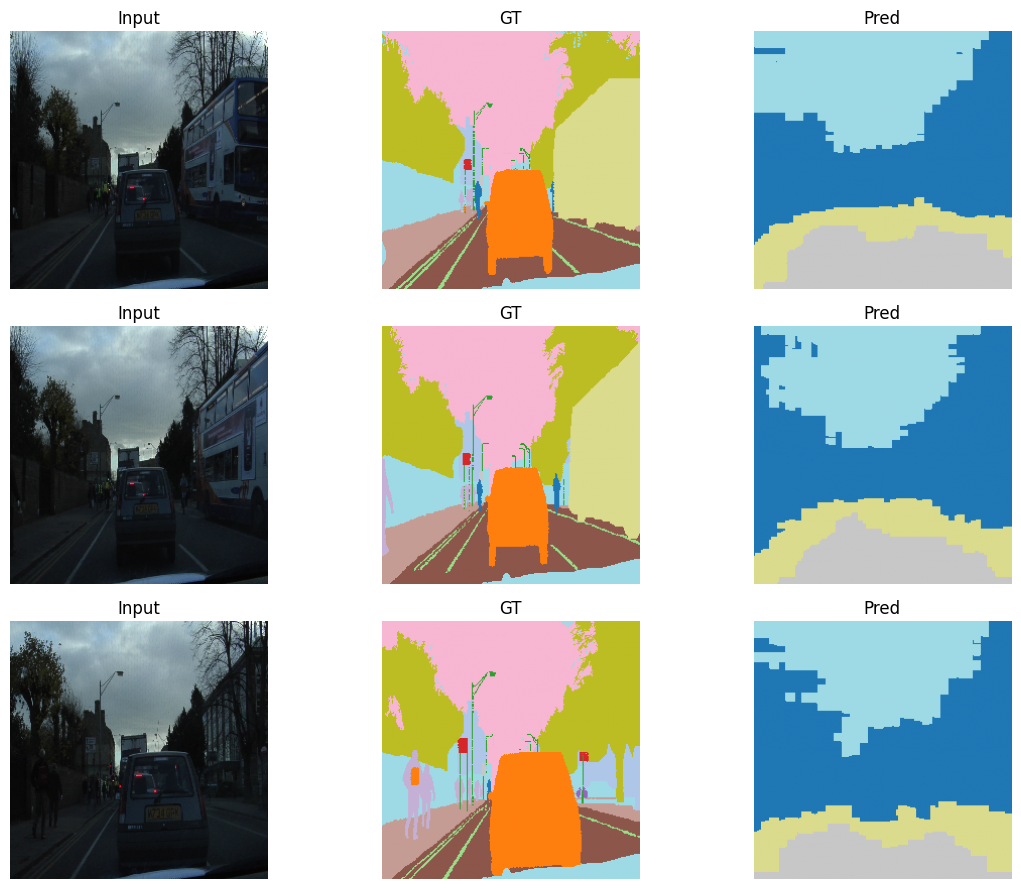

In [51]:
# Show a 5-sample grid of input → ground truth → prediction
visualize_grid(model, val_dataset, indices=[0,1,2])



## Insights & Conclusion

- The model successfully segments **large regions** (background, roads, sky) with high pixel accuracy.  
- Small or rare objects are harder to detect → reflected in low IoU (~18%).  
- Visualizations clearly show areas where the model succeeds and fails, useful for debugging and improvement.

**Future improvements:**  
1. Fine-tune encoder layers for dataset-specific features.  
2. Apply data augmentation for better generalization.  
3. Use class weighting in loss to handle imbalance.  
4. Post-processing to clean predicted masks.  
5. Compare with other architectures (e.g., DeepLabV3) for performance gains.

**Outcome:**  
- Complete semantic segmentation pipeline with **training, evaluation, and visualization**.  
- Ready for practical applications like **defect detection, mask generation, and background removal**.  
- Demonstrates strong **computer vision and PyTorch skills**, suitable for internship reporting and recommendation.
